## AT&T

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import os
import pandas as pd
from aggregators import (
    race, 
    income, 
    redlining, 
    plot_race, 
    speed_breakdown, 
    unserved, 
    bucket_and_bin
)

In [39]:
# inputs
fn_huges = "../data/output/speed_price_hughes.csv.gz"

# outputs
fn_speed = "../data/output/figs/fig1_huges.csv"
fn_fig3a = "../data/output/figs/fig3_income.csv"
fn_fig3b = "../data/output/figs/fig3_race.csv"
fn_fig3c = "../data/output/figs/fig3_redline.csv"

In [40]:
huges = pd.read_csv(fn_huges, compression='gzip')
len(huges)

14

In [41]:
huges.major_city.nunique()

1

In [42]:
huges["median_household_income"]

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
12   NaN
13   NaN
Name: median_household_income, dtype: float64

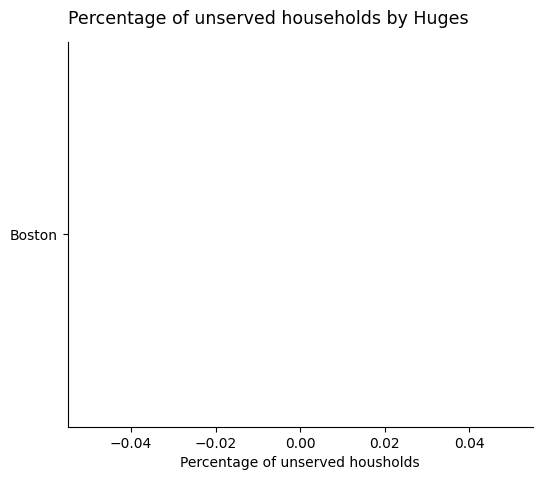

In [43]:
unserved(huges, isp='Huges')
# in this case the graph should be 1 bar to 0%?. Huges Network 
# serves each of these addresses, so 0 of them are unserved.

In [44]:
huges = huges[huges.speed_down != 0]
len(huges)

14

In [45]:
huges = bucket_and_bin(huges)
huges.head()

Boston


,address_full,incorporated_place,major_city,state,lat,lon,block_group,collection_datetime,provider,speed_down,...,redlining_grade,race_perc_non_white,income_lmi,ppl_per_sq_mile,n_providers,income_dollars_below_median,internet_perc_broadband,median_household_income,speed_down_bins,is_slow
0,"33, Leyland Street, Boston, MA, 02125",Boston,Boston,MA,42.320020,-71.070300,2,1.701717e+09,hughes,15,...,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Slow (<25 Mbps),1
1,"46, Sycamore Street, Boston, MA, 02131",Boston,Boston,MA,42.283160,-71.126810,2,1.701717e+09,hughes,15,...,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Slow (<25 Mbps),1
2,"31, Neponset Avenue, Boston, MA, 02122",Boston,Boston,MA,42.296301,-71.055392,5,1.701717e+09,hughes,15,...,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Slow (<25 Mbps),1
3,"108, Fuller Street, Boston, MA, 02124",Boston,Boston,MA,42.282040,-71.070700,2,1.701717e+09,hughes,15,...,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Slow (<25 Mbps),1
4,"10, E Springfield Street, Boston, MA, 02118",Boston,Boston,MA,42.336730,-71.075750,1,1.701717e+09,hughes,15,...,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Slow (<25 Mbps),1


In [46]:
# who gets options?
huges[
    (huges["speed_down"] != huges["fastest_speed_down"])
    & (~huges["fastest_speed_down"].isnull())
]["speed_down"].value_counts(normalize=True)

speed_down
15    1.0
Name: proportion, dtype: float64

In [47]:
# make the above for each city:
city2speeds = pd.DataFrame()
for (city, state), _df in huges.groupby(["major_city", "state"]):
    row = _df.speed_down_bins.value_counts(normalize=True, sort=False).to_frame().T
    row.reset_index(drop=True, inplace=True)
    row["major_city"] = city.title()
    row["state"] = state
    city2speeds = pd.concat([city2speeds, row])
city2speeds.to_csv(fn_speed, index=False)

In [48]:
variety = huges.groupby(['major_city', 'state']).speed_down_bins.value_counts(normalize=True)
homogenous_cities = variety[variety >= .95].index.get_level_values(0)
len(homogenous_cities)

1

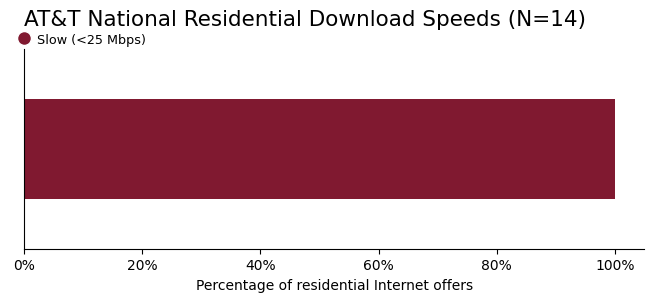

In [49]:
speed_breakdown(huges)

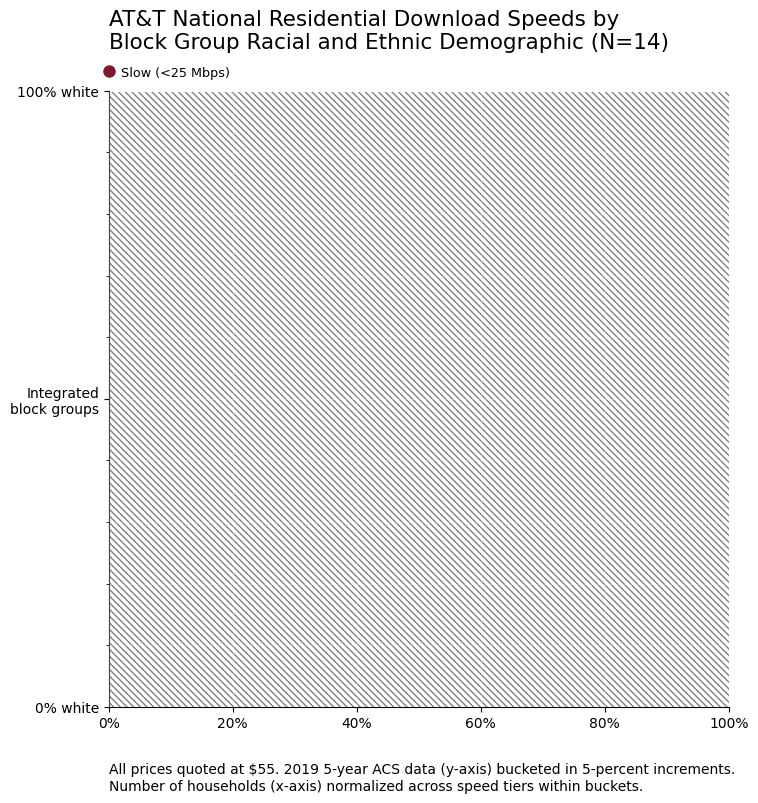

In [51]:
plot_race(huges)

In [52]:
race(huges)

KeyError: 'race_quantile'

In [53]:
income(huges)

KeyError: 'income_level'

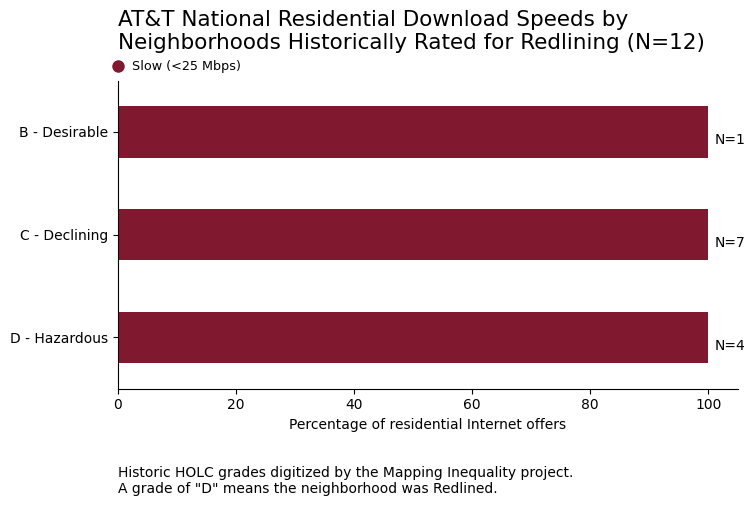

In [54]:
redlining(huges)

## City by City

Boston
Boston


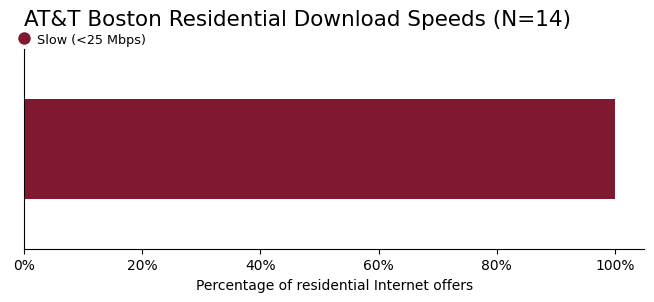

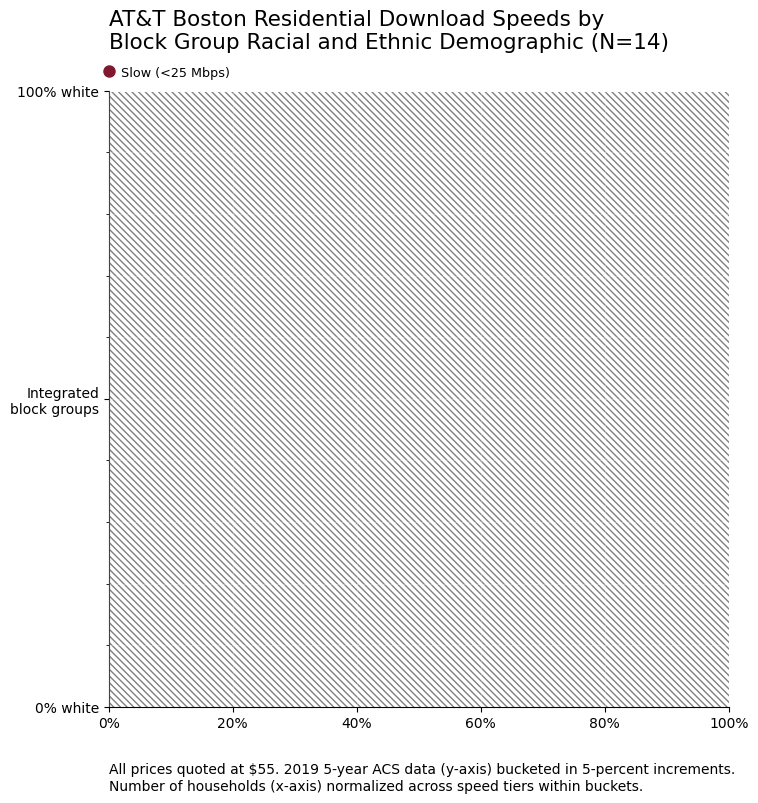

KeyError: 'race_quantile'

In [55]:
for city, _df in huges.groupby("major_city"):
    print(city)
    _df = bucket_and_bin(_df)
    speed_breakdown(_df, location=city.title())
    plot_race(_df, location=city.title())
    race(_df, location=city.title())
    income(_df, location=city.title())
    redlining(_df, location=city.title())
    fn_out = f"../data/intermediary/maps/att/{city}_offers.csv"
    if not os.path.exists(fn_out):
        os.makedirs(os.path.dirname(fn_out), exist_ok=True)
        _df.to_csv(fn_out, index=False)
    print("*" * 79)

## One city's graphs as an example

In [56]:
from pandas.api.types import CategoricalDtype
from config import income_labels

In [57]:
# outputs
fn_fig3a = '../data/output/figs/fig3_income.csv'
fn_fig3b = '../data/output/figs/fig3_race.csv'
fn_fig3c = '../data/output/figs/fig3_redline.csv'

In [ ]:
df_city = bucket_and_bin(huges[huges.major_city == "kansas city"])

In [ ]:
df_city.loc[:, 'income_level'] = df_city['income_level'].astype(
     CategoricalDtype(income_labels, ordered=True)
).copy(deep=True)

to_plot = (df_city.groupby('income_level').speed_down_bins
             .value_counts(normalize=True)
             .sort_index() * 100 ).unstack()
to_plot.to_csv(fn_fig3a)

<ipython-input-21-e28746b9c62d>:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_city.loc[:, 'income_level'] = df_city['income_level'].astype(


In [ ]:
to_plot = (df_city.groupby('race_quantile').speed_down_bins
             .value_counts(normalize=True)
             .sort_index() * 100 ).unstack()
to_plot.to_csv(fn_fig3b)

In [ ]:
to_plot = (df_city.groupby('redlining_grade').speed_down_bins
             .value_counts(normalize=True)
             .sort_index() * 100 ).unstack()
to_plot.to_csv(fn_fig3c)

In [ ]:
# outputs
fn_fig_story_a = '../data/output/figs/story_income_{city}.csv'
fn_fig_story_b = '../data/output/figs/story_race_{city}.csv'
fn_fig_story_c = '../data/output/figs/story_redline_{city}.csv'

In [ ]:
for city in ['new orleans']:
    df_city = bucket_and_bin(att[att.major_city == city])
    df_city.loc[:, 'income_level'] = df_city['income_level'].astype(
         CategoricalDtype(income_labels, ordered=True)
    ).copy(deep=True)

    to_plot = (df_city.groupby('income_level').speed_down_bins
                 .value_counts(normalize=True)
                 .sort_index() * 100 ).unstack()
    to_plot['major_city'] = city
    to_plot.to_csv(fn_fig_story_a.format(city=city.replace(' ', '_')))
    to_plot = (df_city.groupby('race_quantile').speed_down_bins
                 .value_counts(normalize=True)
                 .sort_index() * 100 ).unstack()
    to_plot['major_city'] = city
    to_plot.to_csv(fn_fig_story_b.format(city=city.replace(' ', '_')))
    to_plot = (df_city.groupby('redlining_grade').speed_down_bins
                 .value_counts(normalize=True)
                 .sort_index() * 100 ).unstack()
    to_plot['major_city'] = city
    to_plot.to_csv(fn_fig_story_c.format(city=city.replace(' ', '_')))

<ipython-input-25-1fc2c4f5d3da>:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_city.loc[:, 'income_level'] = df_city['income_level'].astype(


In [ ]:
# how many addresses got 6 Mbps or less
len(huges[huges.speed_down <= 6])

33671

In [ ]:
# how many cities got 6 Mbps or less
huges[huges.speed_down <= 6].major_city.nunique()

20

In [ ]:
# how many addresses below 25 Mbps were also offered an upgrade?
huges[(huges.speed_down < huges.fastest_speed_down) & (huges.speed_down < 25)]

,address_full,incorporated_place,major_city,state,lat,lon,block_group,collection_datetime,provider,speed_down,...,n_providers,income_dollars_below_median,internet_perc_broadband,median_household_income,income_level,speed_down_bins,race_quantile,is_slow,race_perc,color
